### Interpret Results

In [1]:
# Run this script to add the src directory to the python path

from notebook_utils import modify_sys_path, get_src_dir_path

modify_sys_path()

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re

from src.utils import calculate_min_Va_by_KL_threshold, calculate_min_Va_by_KL_rank

In [3]:
# results_directory = 'results/logistic_regression_3/experiment_2/active_learning/dataset_specified/'

results_directory = 'results/logistic_regression_3/experiment_2/'

In [4]:
shots = 15

In [5]:
# Load the results
df_list = []
for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"results_{shots}_shot" in filename:
        save_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
        df_list.append(save_data)

In [6]:
D_data = None

for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"D_{shots}" in filename:
        D_data = pd.read_csv(get_src_dir_path(results_directory) + filename)

In [7]:
for save_data in df_list:
    # z_data = calculate_min_Va_by_KL_threshold(z_data, threshold=0.005, forward_kl=True)
    save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=5, forward_kl=True)

In [8]:

PROB_LABELS = ["0", "1"]

x_x1_list = []
total_uncertainty_list = []
kl_pyx_pyxz_list = []
kl_pyxz_pyx_list = []
min_Va_list = []    
max_Ve_list = []
z_value_for_min_Va_list = []

prob_y_xz_list = []
prob_y_x_list = []
within_threshold_list = []


for z_df in df_list:
    try:
        x_x1 = z_df['x_x1'].values[0]
        x_x1_list.append(x_x1)
        total_uncertainty = z_df["H[p(y|x,D)]"].values[0]
        total_uncertainty_list.append(total_uncertainty)
        prob_y_xz = {}
        prob_y_x = {}
        # index where z_value_for_min_Va is True
        min_Va_index = z_df[z_df["z_value_for_min_Va"]].index[0]
        z_value_for_min_Va_list.append(z_df["z_x1"].values[min_Va_index])
        for label in PROB_LABELS:
            prob_y_xz[label] = z_df[f"p(y={label}|x,z,D)"].values[min_Va_index]
            prob_y_x[label] = z_df[f"p(y={label}|x,D)"].values[min_Va_index]
        prob_y_xz_list.append(prob_y_xz)
        prob_y_x_list.append(prob_y_x)
        kl_pyx_pyxz = z_df["kl_pyx_pyxz"].values[min_Va_index]
        kl_pyx_pyxz_list.append(kl_pyx_pyxz)
        kl_pyxz_pyx = z_df["kl_pyxz_pyx"].values[min_Va_index]
        kl_pyxz_pyx_list.append(kl_pyxz_pyx)
        min_Va = z_df["min_Va"].values[0]
        min_Va_list.append(min_Va)
        max_Ve = z_df["max_Ve"].values[0]
        max_Ve_list.append(max_Ve)
        
        within_threshold_list.append(z_df[z_df["within_threshold"]]["z_x1"].values)
        
    except:
        pass
    
# Create a dataframe from the lists
data = {'x_x1': x_x1_list,
        'total_uncertainty': total_uncertainty_list,
        'min_Va': min_Va_list,
        'max_Ve': max_Ve_list,
        'kl_pyx_pyxz': kl_pyx_pyxz_list,
        'kl_pyxz_pyx': kl_pyxz_pyx_list,
        'z_value_for_min_Va': z_value_for_min_Va_list,
        'within_threshold': within_threshold_list
        }

for label in PROB_LABELS:
    data[f"p(y={label}|x,z,D)"] = [d[label] for d in prob_y_xz_list]
    data[f"p(y={label}|x,D)"] = [d[label] for d in prob_y_x_list]

num_Va = len(min_Va_list)

# reduce the length of list to the number of num_Va
for key in data.keys():
    data[key] = data[key][:num_Va]

shots_df = pd.DataFrame(data)

shots_df = shots_df.sort_values(by='x_x1')


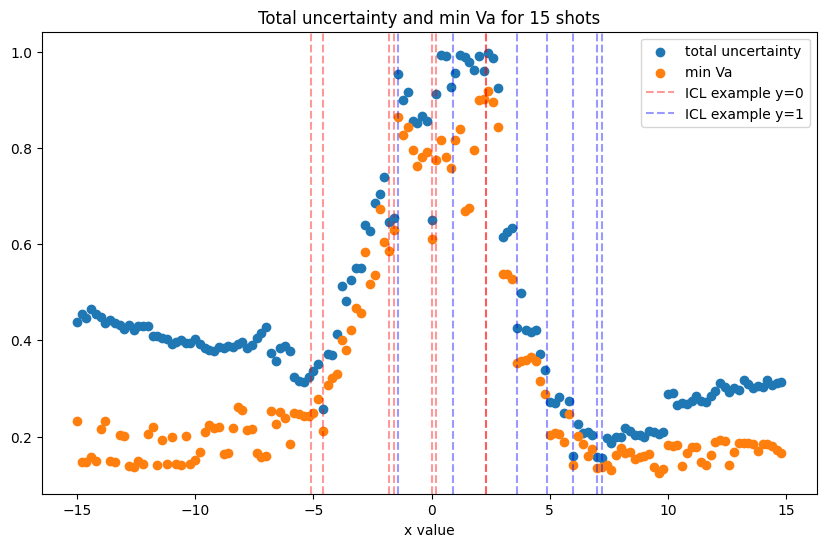

In [9]:
# plot x vs total uncertainty and min Va

plt.figure(figsize=(10, 6))
plt.scatter(shots_df['x_x1'], shots_df['total_uncertainty'], label='total uncertainty')
plt.scatter(shots_df['x_x1'], shots_df['min_Va'], label='min Va')

# vertical line for the true x
label_0_seen = False
label_1_seen = False
for i, row in D_data.iterrows():
    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = 'ICL example y=0'
        else:
            label_string = None
        plt.axvline(x=row['x1'], color='r', linestyle='--', alpha=0.4, label=label_string)
    else:
        if not label_1_seen:
            label_1_seen = True
            label_string = 'ICL example y=1'
        else:
            label_string = None
        plt.axvline(x=row['x1'], color='b', linestyle='--', alpha=0.4, label=label_string)
plt.title(f"Total uncertainty and min Va for {shots} shots")

# plt.yscale('log')
plt.xlabel('x value')
plt.legend()
plt.show()

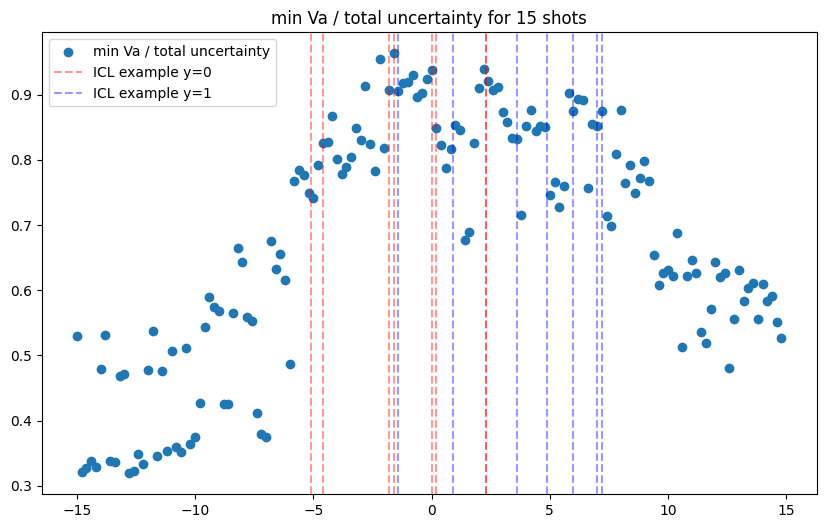

In [10]:
# min Va total uncertainty ratio

shots_df['min_Va_total_uncertainty_ratio'] = shots_df['min_Va'] / shots_df['total_uncertainty']

plt.figure(figsize=(10, 6))
plt.scatter(shots_df['x_x1'], shots_df['min_Va_total_uncertainty_ratio'], label='min Va / total uncertainty')

# vertical line for the true x
label_0_seen = False
label_1_seen = False
for i, row in D_data.iterrows():
    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = 'ICL example y=0'
        else:
            label_string = None
        plt.axvline(x=row['x1'], color='r', linestyle='--', alpha=0.4, label=label_string)
    else:
        if not label_1_seen:
            label_1_seen = True
            label_string = 'ICL example y=1'
        else:
            label_string = None
        plt.axvline(x=row['x1'], color='b', linestyle='--', alpha=0.4, label=label_string)
plt.title(f"min Va / total uncertainty for {shots} shots")

# plt.yscale('log')
plt.legend()
plt.show()

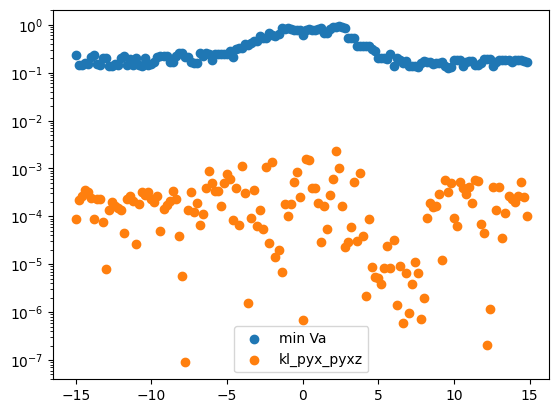

In [11]:
# plot x vs the kl divergence

plt.figure()
plt.scatter(shots_df['x_x1'], shots_df['min_Va'], label='min Va')
plt.scatter(shots_df['x_x1'], shots_df['kl_pyx_pyxz'], label='kl_pyx_pyxz')
plt.yscale('log')
plt.legend()
plt.show()


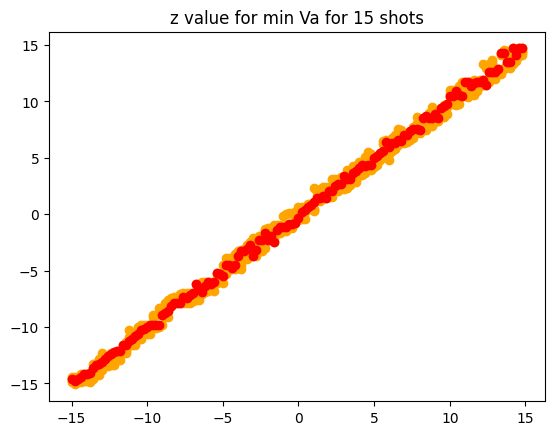

In [12]:
# plot x vs z_value_for_min_Va and within_threshold_values


plt.figure()
for i, row in shots_df.iterrows():
    x = row["x_x1"]
    within_threshold = row["within_threshold"]
    for value in within_threshold:
        plt.scatter(x, value, c='orange')
plt.scatter(shots_df['x_x1'], shots_df['z_value_for_min_Va'], c='r', label='z_value_for_min_Va')
plt.title(f"z value for min Va for {shots} shots")
plt.show()